In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce
from helpers import *
import numpy as np
from scipy.optimize import curve_fit
import tifffile
from sklearn.linear_model import LinearRegression


### DANIEL BLOCK IMAGES

In [4]:


# Load the TIFF file
file_path = '/Users/mattice/Desktop/MLProject_BrowianMotion/ml-project-2-big-burger/real-data/blocks_64x64x16_70_01/block-001-6.658-0.057-456.tif'
images = tifffile.imread(file_path)

# Define a 2D Gaussian model
def two_d_gaussian(coords, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = coords
    xo = float(x0)
    yo = float(y0)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    g = offset + amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))
    return g.ravel()

# Fit a 2D Gaussian to an image
def fit_gaussian_to_image(img):
    y_size, x_size = img.shape
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)

    amplitude_guess = np.max(img)
    y0_guess, x0_guess = np.unravel_index(np.argmax(img), img.shape)
    sigma_x_guess = sigma_y_guess = 2.0
    theta_guess = 0
    offset_guess = np.median(img)

    initial_guess = (amplitude_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess, theta_guess, offset_guess)
    popt, _ = curve_fit(two_d_gaussian, (x, y), img.ravel(), p0=initial_guess, maxfev=2000)
    x0, y0 = popt[1], popt[2]
    return x0, y0

# Extract centroids from the images
def get_centroids(images):
    centroids = []
    for img in images:
        x0, y0 = fit_gaussian_to_image(img)
        centroids.append((x0, y0))
    return np.array(centroids)

# Compute Mean Squared Displacement (MSD)
def compute_msd(positions, dt):
    N = positions.shape[0]
    msd = []
    time_lags = []
    for lag in range(1, N):
        diffs = positions[lag:] - positions[:-lag]
        squared_diffs = np.sum(diffs**2, axis=1)
        msd.append(np.mean(squared_diffs))
        time_lags.append(lag * dt)
    return np.array(time_lags), np.array(msd)

# Fit diffusion coefficient from MSD
def fit_diffusion_coefficient(time_lags, msd):
    model = LinearRegression(fit_intercept=False)
    model.fit(time_lags.reshape(-1, 1), msd)  # Fit model to data
    slope = model.coef_[0]
    D_estimated = slope / 4
    return D_estimated



# Parameters
dt = 0.1  # seconds per frame

# Compute centroids, MSD, and diffusion coefficient
centroids = get_centroids(images)
time_lags, msd = compute_msd(centroids, dt)
D_pixel_units = fit_diffusion_coefficient(time_lags, msd)

# Output results
print("Centroids (pixels):", centroids)
print("Time Lags (s):", time_lags)
print("MSD (pixels^2):", msd)
print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)


Centroids (pixels): [[31.47099448 31.32949638]
 [31.59255559 32.1890121 ]
 [31.17773527 31.80919774]
 [31.2513118  29.39675575]
 [31.39305183 30.65565563]
 [32.26339492 31.04295683]
 [30.87780936 32.57972818]
 [28.79158851 32.19539244]
 [30.5352007  33.78194489]
 [31.60816    33.85112603]
 [31.98506452 32.61951235]
 [31.51624651 32.57325196]
 [31.5273211  32.58478512]
 [33.30786687 31.97312632]
 [34.35599761 30.04150226]
 [33.85097422 29.9393301 ]]
Time Lags (s): [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
MSD (pixels^2): [ 2.36155431  5.05024466  6.41841359  6.49150812  8.31920094 11.09308155
 11.23446526  9.50563498  6.32149422  4.42789246  4.57669551  6.21163811
  8.89312716 10.07184784  7.59686586]
Diffusion Coefficient D (pixels^2/s): 1.8490914087300039


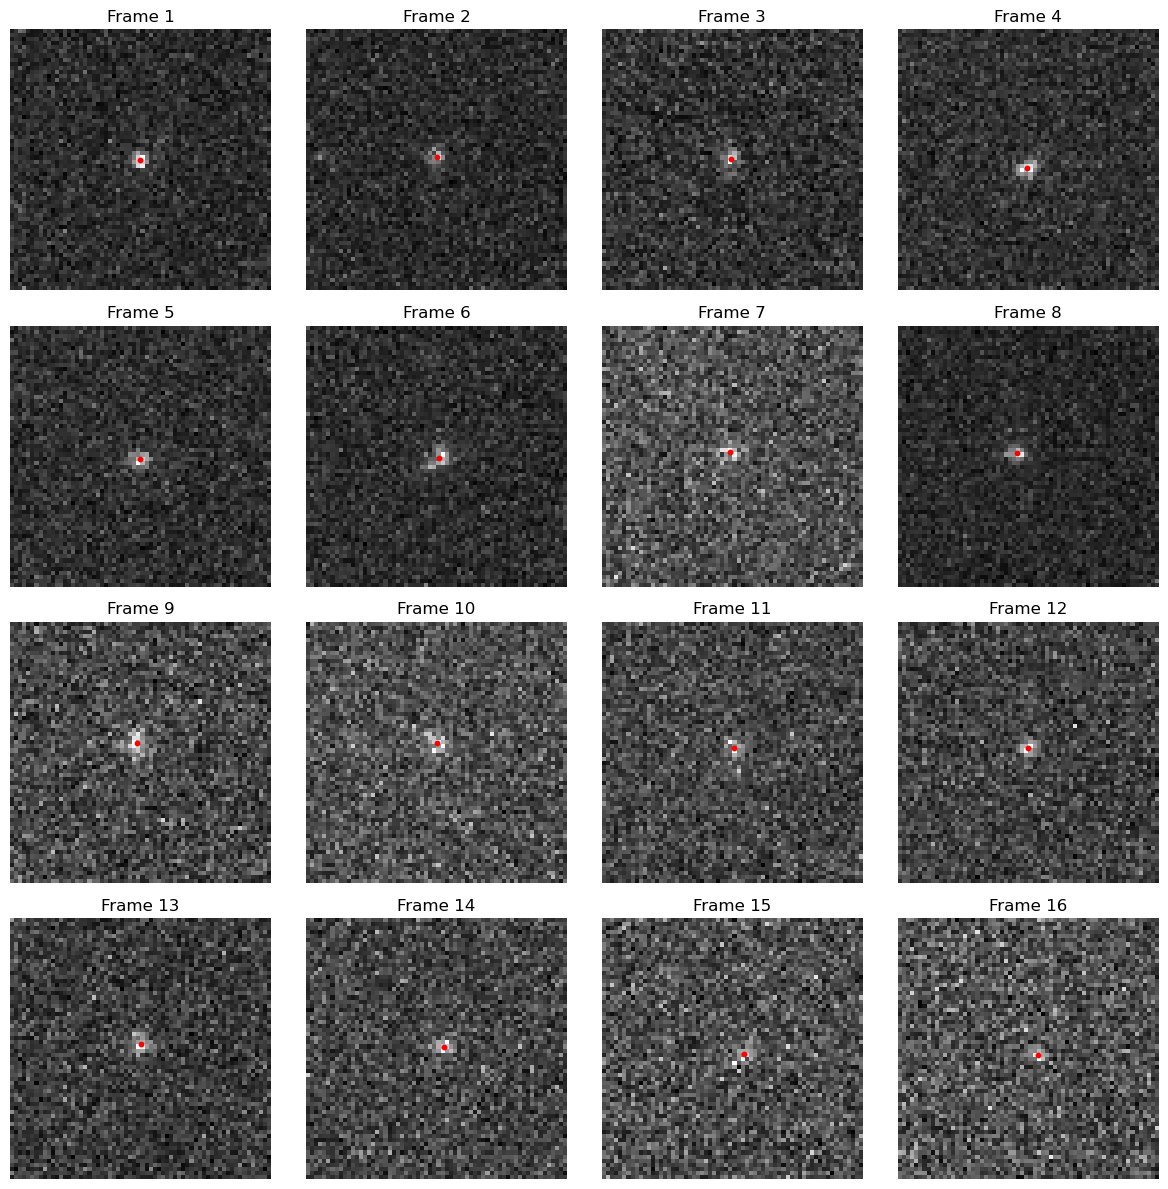

In [5]:
import matplotlib.pyplot as plt

# Function to plot images with centroids
def plot_images_with_centroids(images, centroids):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray', origin='lower')
        ax.scatter(centroids[i, 0], centroids[i, 1], color='red', s=10, label='Centroid')  # Reduced point size
        ax.set_title(f"Frame {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_images_with_centroids(images, centroids)


In [6]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import center_of_mass
import tifffile

# Load the TIFF file
file_path = '/Users/mattice/Desktop/MLProject_BrowianMotion/ml-project-2-big-burger/real-data/blocks_64x64x16_70_01/block-001-6.658-0.057-456.tif'
images = tifffile.imread(file_path)

# Define a 2D Gaussian model
def two_d_gaussian(coords, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = coords
    xo = float(x0)
    yo = float(y0)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    g = offset + amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))
    return g.ravel()

# Fit a 2D Gaussian to an image, fallback to center_of_mass if fitting fails
def fit_gaussian_with_fallback(img):
    y_size, x_size = img.shape
    x = np.linspace(0, x_size - 1, x_size)
    y = np.linspace(0, y_size - 1, y_size)
    x, y = np.meshgrid(x, y)

    amplitude_guess = np.max(img)
    y0_guess, x0_guess = np.unravel_index(np.argmax(img), img.shape)
    sigma_x_guess = sigma_y_guess = 2.0
    theta_guess = 0
    offset_guess = np.median(img)

    initial_guess = (amplitude_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess, theta_guess, offset_guess)

    try:
        popt, _ = curve_fit(two_d_gaussian, (x, y), img.ravel(), p0=initial_guess, maxfev=2000)
        x0, y0 = popt[1], popt[2]
    except (RuntimeError, ValueError):
        # Fallback to center of mass if fitting fails
        y0, x0 = center_of_mass(img)

    return x0, y0

# Extract centroids from the images
def get_centroids(images):
    centroids = []
    for img in images:
        x0, y0 = fit_gaussian_with_fallback(img)
        centroids.append((x0, y0))
    return np.array(centroids)

# Compute Mean Squared Displacement (MSD)
def compute_msd(positions, dt):
    N = positions.shape[0]
    msd = []
    time_lags = []
    for lag in range(1, N):
        diffs = positions[lag:] - positions[:-lag]
        squared_diffs = np.sum(diffs**2, axis=1)
        mean_squared_diff = np.mean(squared_diffs)
        msd.append(max(mean_squared_diff, 0))  # Ensure non-negative MSD
        time_lags.append(lag * dt)
    return np.array(time_lags), np.array(msd)

# Fit diffusion coefficient from MSD
def fit_diffusion_coefficient(time_lags, msd):
    def linear(t, a, b):
        return a * t + b
    popt, _ = curve_fit(linear, time_lags, msd, p0=(1, 0))
    D = popt[0] / 4.0
    return D

# Parameters
dt = 0.1  # seconds per frame

# Compute centroids, MSD, and diffusion coefficient
centroids = get_centroids(images)
time_lags, msd = compute_msd(centroids, dt)
D_pixel_units = fit_diffusion_coefficient(time_lags, msd)

# Output results
print("Centroids (pixels):", centroids)
print("Time Lags (s):", time_lags)
print("MSD (pixels^2):", msd)
print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)


Centroids (pixels): [[31.47099448 31.32949638]
 [31.59255559 32.1890121 ]
 [31.17773527 31.80919774]
 [31.2513118  29.39675575]
 [31.39305183 30.65565563]
 [32.26339492 31.04295683]
 [30.87780936 32.57972818]
 [28.79158851 32.19539244]
 [30.5352007  33.78194489]
 [31.60816    33.85112603]
 [31.98506452 32.61951235]
 [31.51624651 32.57325196]
 [31.5273211  32.58478512]
 [33.30786687 31.97312632]
 [34.35599761 30.04150226]
 [33.85097422 29.9393301 ]]
Time Lags (s): [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
MSD (pixels^2): [ 2.36155431  5.05024466  6.41841359  6.49150812  8.31920094 11.09308155
 11.23446526  9.50563498  6.32149422  4.42789246  4.57669551  6.21163811
  8.89312716 10.07184784  7.59686586]
Diffusion Coefficient D (pixels^2/s): 0.43357165099134154


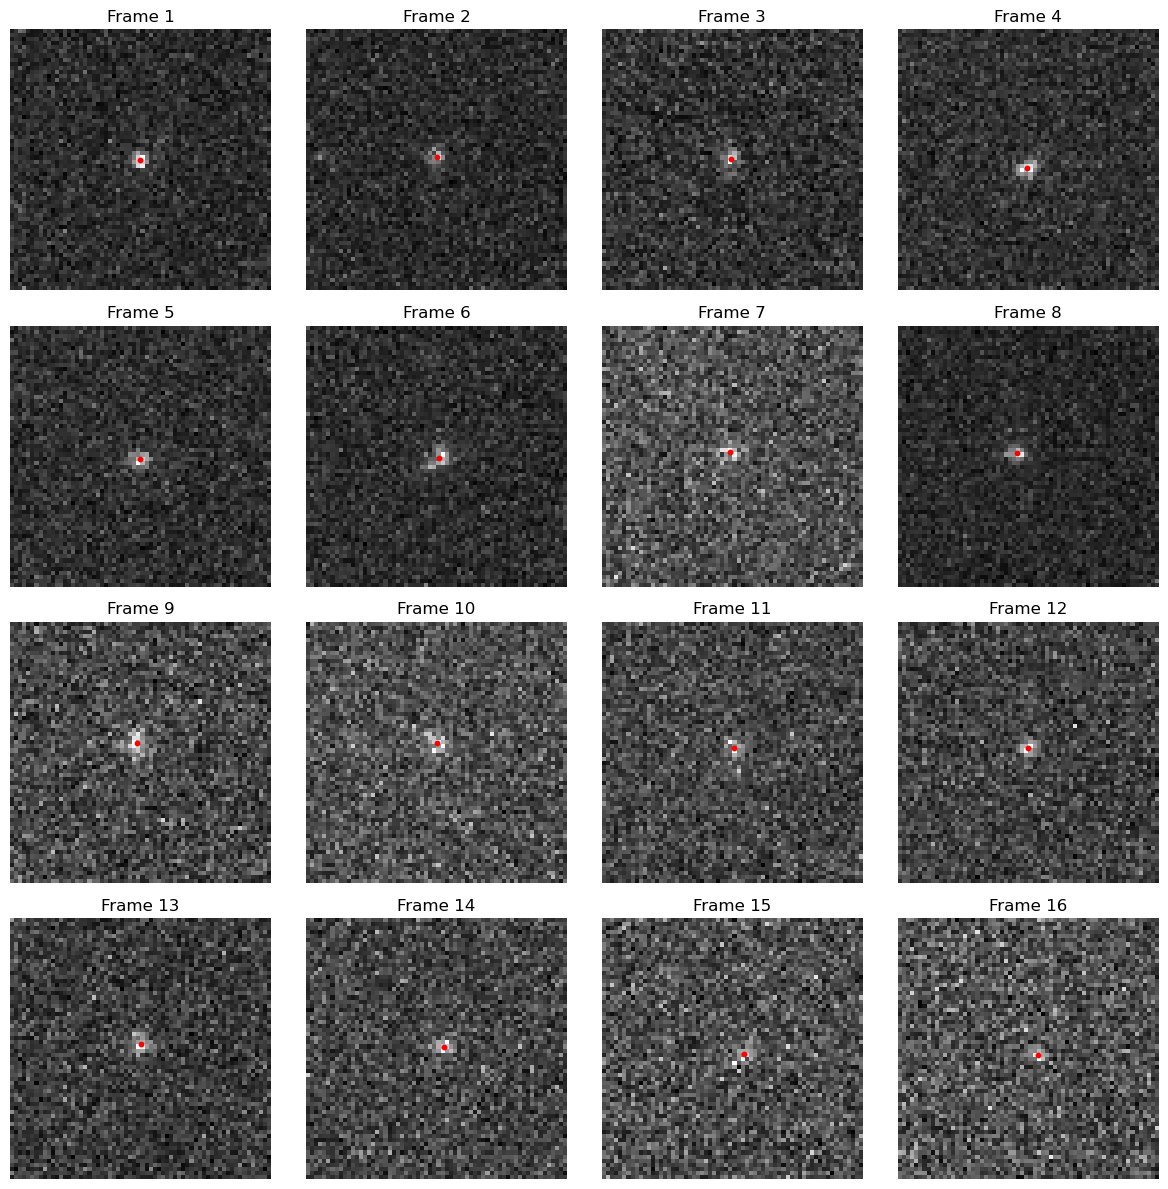

In [7]:
import matplotlib.pyplot as plt

# Function to plot images with centroids
def plot_images_with_centroids(images, centroids):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray', origin='lower')
        ax.scatter(centroids[i, 0], centroids[i, 1], color='red', s=10, label='Centroid')  # Reduced point size
        ax.set_title(f"Frame {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_images_with_centroids(images, centroids)


###  IMAGES GENEREES

Generating trajectories: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

running program on each 11 cpu core of the computer



Generating images and estimating D: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


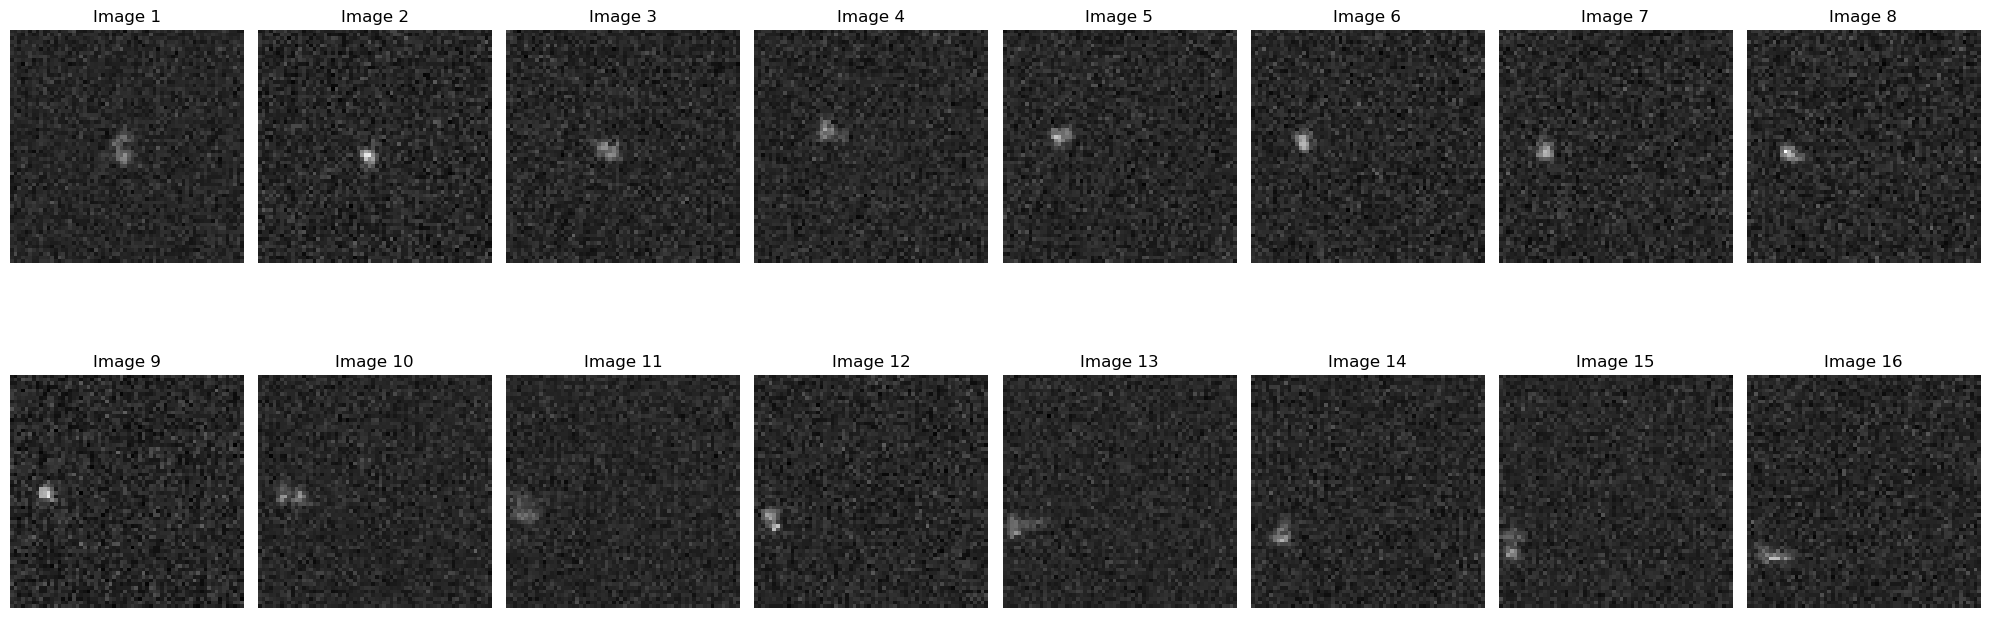

Centroids (pixels): [[30.24727383 32.75267242]
 [29.62513482 34.28027518]
 [27.36565837 32.6531799 ]
 [19.45443925 27.32034096]
 [15.19225467 28.90610071]
 [13.80027225 30.44434192]
 [12.23913799 33.01503994]
 [10.92593028 33.50437625]
 [ 9.40141221 32.17489732]
 [ 8.96176318 32.94381949]
 [ 4.53485495 37.06117471]
 [ 4.37109228 39.36866408]
 [ 3.28000784 41.28139343]
 [ 7.88839814 43.84486213]
 [ 3.00360964 46.94268368]
 [ 7.13144354 49.61900802]]
Time Lags (s): [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15]
MSD (pixels^2): [ 18.30591842  46.29030825  89.4007072  127.21115207 174.15283587
 229.31073181 287.47467382 354.98971052 441.11321117 548.46171158
 622.14284823 702.68141879 729.75365339 842.40826538 818.81488668]
Diffusion Coefficient D (pixels^2/s): 1336.2887725391047
Diffusion Coefficient D (nm^2/s): 13362887.725391047
AAAA [33581.09699846]


In [8]:



# Fit the diffusion coefficient from MSD
def fit_diffusion_coefficient(time_lags, msd):
    model = LinearRegression(fit_intercept=False)
    model.fit(time_lags.reshape(-1, 1), msd)
    slope = model.coef_[0]
    D_estimated = slope / 4
    return D_estimated

### Parameters for the simulation and image generation
nframes = 16    # number of frames
nposframe = 10
dt = 0.01        # seconds between frames
DGen = 20000     # diffusion coefficient in nm^2/s
npixel = 64
pixelsize = 100  # nm per pixel
fwhm_psf = 200   # nm
factor_hr = 5
flux = 100
poisson_noise = 100
gaussian_noise = 10
background = 100
normalizeValue = 1000

# Generate images and ground truth data
images_arr, estimatedDs = generateImagesAndEstimateDMAXD(
    1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize, flux, background, 
    poisson_noise, gaussian_noise, normalizeValue
)
images = images_arr[0]

# Display the first 16 images
global_min_gen = np.min(images)
global_max_gen = np.max(images)
num_images = min(16, len(images))
rows, cols = 2, 8
plt.figure(figsize=(20, 8))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i], cmap="gray", vmin=global_min_gen, vmax=global_max_gen)
    plt.title(f"Image {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Compute centroids, MSD, and diffusion coefficient
centroids = get_centroids(images)   # shape: (nframes, 2)
time_lags, msd = compute_msd(centroids, dt)
D_pixel_units = fit_diffusion_coefficient(time_lags, msd)

# Convert D from pixels^2/s to nm^2/s if desired
# Since 1 pixel = pixelsize nm, D_nm = D_pixel_units * (pixelsize^2)
D_nm_s = D_pixel_units * (pixelsize**2)

# Print results
print("Centroids (pixels):", centroids)
print("Time Lags (s):", time_lags)
print("MSD (pixels^2):", msd)

print("Diffusion Coefficient D (pixels^2/s):", D_pixel_units)
print("Diffusion Coefficient D (nm^2/s):", D_nm_s)
print('AAAA',estimatedDs)

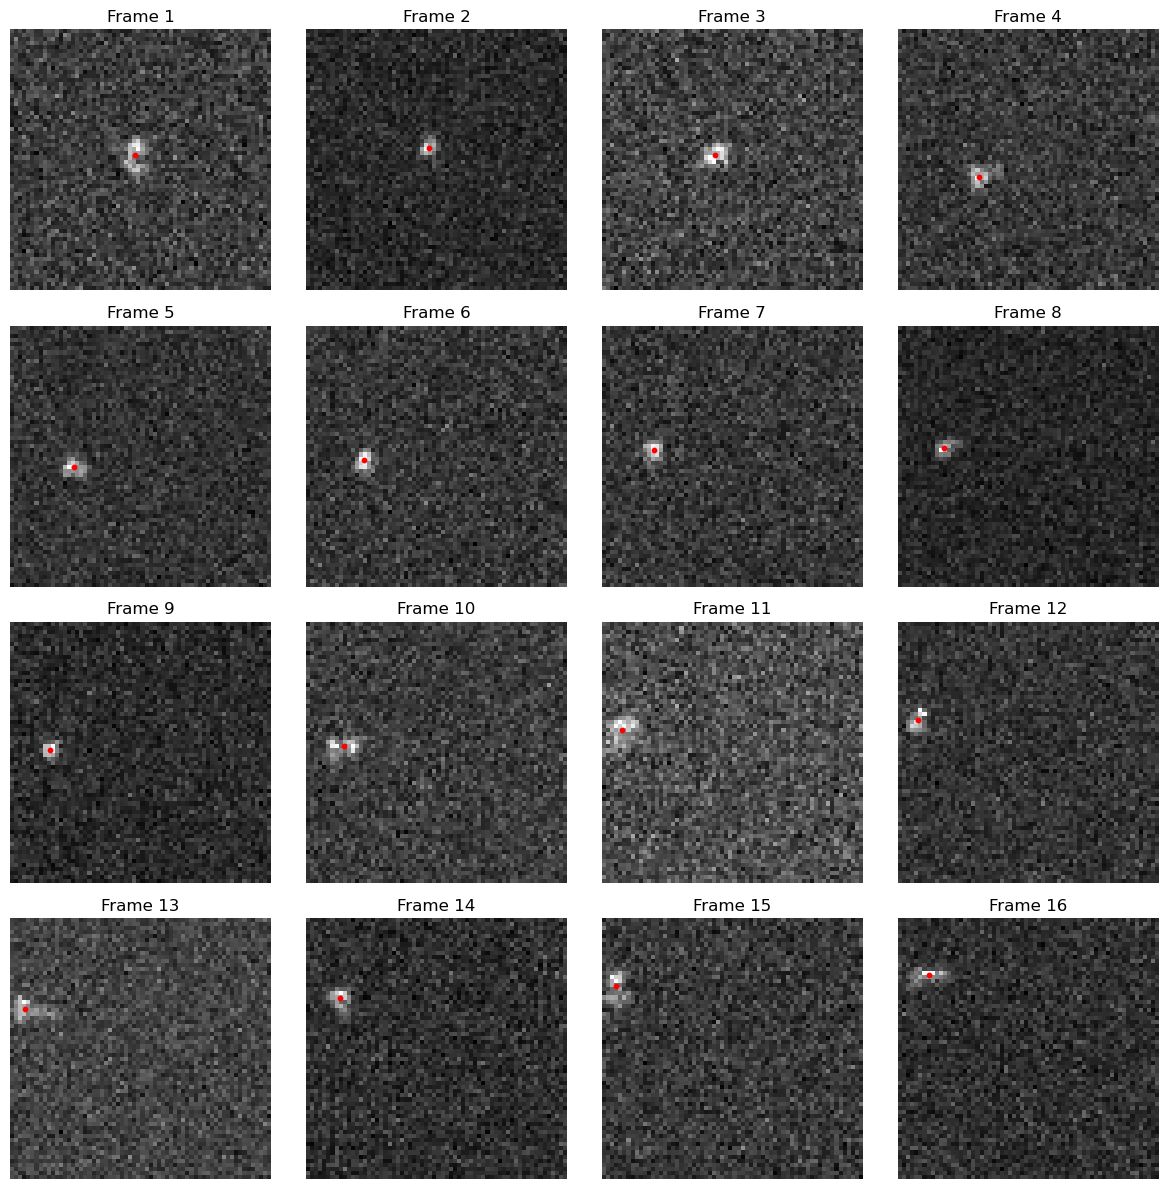

In [9]:
def plot_images_with_centroids(images, centroids):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i], cmap='gray', origin='lower')
        ax.scatter(centroids[i, 0], centroids[i, 1], color='red', s=10, label='Centroid')  # Reduced point size
        ax.set_title(f"Frame {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_images_with_centroids(images, centroids)